In [2]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [23]:
from spire.utils import *
from spire.operators.image import *
import pywt

In [179]:
from scipy.misc import ascent
img1 = ascent().astype("f")
img2 = np.load("data/cookie.npz")["data"]
img3 = np.load("data/Brain512.npz")["data"]
img4 = np.load("data/SL512.npz")["data"]
img5 = np.load("data/lena.npz")["data"]

In [180]:
compressibility(pywt.coeffs_to_array(pywt.wavedec2(img5, "haar", mode="periodization"))[0])

(63511.95312500008, 1.2335402668968307)

In [187]:
def compressibility(c, show=False, q=None):
    # Sort the coefficients in decreasing order of magnitude
	c1 = np.abs(c.ravel())
	c1.sort()
	c1 = c1[::-1]
    # Take logarithm
	c1l = np.log(c1)
    # 
	R = c1[0]
    # Indices
	t = 1+np.arange(c1.shape[0])
	qv = ((c1l - c1l[0])/np.log(t))[1:]
	qv = qv[qv!=0] # In the case of first value being repeated
	p = -1./qv.max()
	if show:
		plt.figure()
		#plt.plot(c1l)
		#plt.plot(np.log(R * t**(-1./p)))
		plt.plot(c1)
		if q is None: q = p
		plt.plot(R * t**(-1./q))
		plt.show()
	return R, p

In [188]:
def approx_image(img, K, wname, levels=None, return_compressibility=False):
    c = pywt.wavedec2(img, wname, level=levels, mode="periodization") # pywt 0.5.0
    coeffs, slices = pywt.coeffs_to_array(c)
    coeffs_ravel = np.copy(coeffs.ravel()) # !
    coeffs_sort_indices = np.argsort(np.abs(coeffs.ravel()))
    # Keep the K largest coeffs, set to 0 the others
    coeffs_ravel[coeffs_sort_indices[:-K]] = 0
    coeffs_K = coeffs_ravel.reshape(coeffs.shape)
    # 
    C_pywt = pywt.array_to_coeffs(coeffs_K, slices, output_format='wavedec2')
    rec = pywt.waverec2(C_pywt, wname, mode="periodization") # pywt 0.5.0
    if return_compressibility:
        return compressibility(coeffs), rec
    return rec
    
def approx_error(img, K, wname, levels=None, return_compressibility=False):
    result = approx_image(img, K, wname, levels=levels, return_compressibility=return_compressibility)
    if return_compressibility:
        (R, p), img_K = result
    else:
        img_K = result
    #err = np.abs(img - img_K).max() # L-inf
    err = sqrt(norm2sq(img - img_K)) # L-2
    if return_compressibility:
        return R, p, err
    else:
        return err
    

104.053335745


<IPython.core.display.Javascript object>


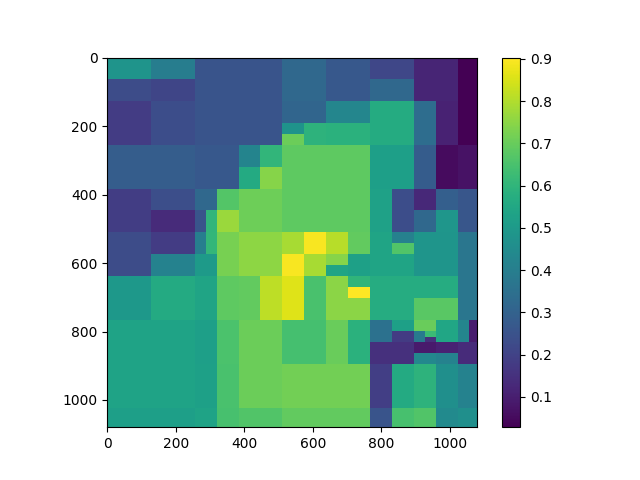

In [192]:
K = 100
print approx_error(img2, K, "haar", levels=8)

ims(approx_image(img2, K, "haar", levels=8))

In [191]:
print approx_image(img2, 100, "haar", levels=8, return_compressibility=True)


((193.09303, 15.915368866230647), array([[ 0.4818615 ,  0.4818615 ,  0.4818615 , ...,  0.02841724,
         0.02841724,  0.02841724],
       [ 0.4818615 ,  0.4818615 ,  0.4818615 , ...,  0.02841724,
         0.02841724,  0.02841724],
       [ 0.4818615 ,  0.4818615 ,  0.4818615 , ...,  0.02841724,
         0.02841724,  0.02841724],
       ..., 
       [ 0.52265918,  0.52265918,  0.52265918, ...,  0.4625698 ,
         0.4625698 ,  0.4625698 ],
       [ 0.52265918,  0.52265918,  0.52265918, ...,  0.4625698 ,
         0.4625698 ,  0.4625698 ],
       [ 0.52265918,  0.52265918,  0.52265918, ...,  0.4625698 ,
         0.4625698 ,  0.4625698 ]], dtype=float32))


In [212]:
# Image
img = img1
# Number of largest sample kept for the approximation
K_ = np.int32(10**np.array([2, 2.5, 3, 3.5, 4, 4.5, 5]))
# Wavelet name
wname = "haar"
# Wavelet levels
levels = None # None = max



R_table = []
p_table = []
err_table = []
err_model_table = []
for K in K_:
    R, p, err = approx_error(img, K, wname, levels=levels, return_compressibility=True)
    R_table.append(R) # R and p should only depend
    p_table.append(p) # on the image, not on K
    err_table.append(err)
    err_model = R * K**(1./2 - 1./p)
    err_model_table.append(err_model)


    
    

In [213]:
print p_table
print R_table
print err_table
print err_model_table

[1.3973137478078244, 1.3973137478078244, 1.3973137478078244, 1.3973137478078244, 1.3973137478078244, 1.3973137478078244, 1.3973137478078244]
[44789.684, 44789.684, 44789.684, 44789.684, 44789.684, 44789.684, 44789.684]
[17983.069370938876, 15447.948731142267, 12457.543899180127, 9287.903100269727, 5866.717651293609, 2379.7029226355126, 406.999692874577]
[16590.528567724756, 12944.886984187995, 10097.20879261584, 7877.3495603695073, 6145.2909704166623, 4794.1907331321563, 3740.103021213356]


<IPython.core.display.Javascript object>


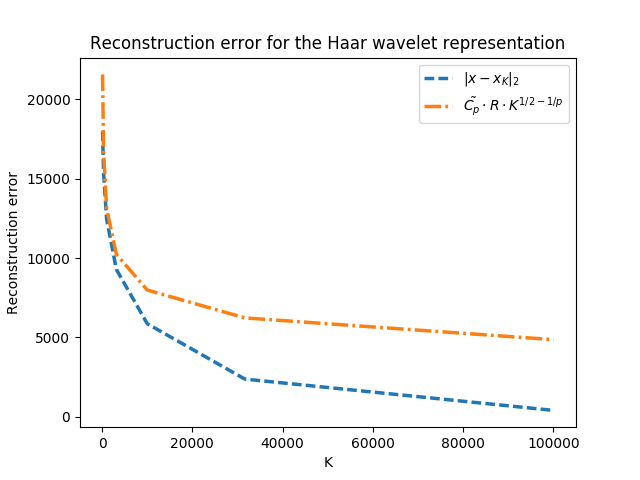

In [214]:
plt.figure()
plt.plot(K_, err_table, '--', lw=2.5)
plt.plot(K_, 1.3*np.array(err_model_table), '-.', lw=2.5,)
plt.legend(["$\\left\| x - x_K \\right\|_2$", "$\\tilde{C_p} \cdot R \cdot K^{1/2-1/p}$"])
plt.xlabel("K")
plt.ylabel("Reconstruction error")
plt.title("Reconstruction error for the Haar wavelet representation")
plt.show()

The compressibility computation can give p > 2, which makes the estimate diverge.

The interesting case is for very small p.

This computation of compressibility, although giving theoretical guarantees, can yield high "p" due to the first largest coefficients being similar.




